## Telco Customer Churn Analysis
### 1. Import packages and merge dataset

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

sys.path.append("../src")
import utils

In [2]:
churn = pd.read_csv('../data/raw/customer-churn.csv')
customer = pd.read_csv('../data/raw/customer-data.csv')
service = pd.read_csv('../data/raw/service-subscription.csv')
print(f'Before merge: \n\t Churn data: {churn.shape}, \n\t customer data: {customer.shape}, \n\t service subscription: {service.shape}')

Before merge: 
	 Churn data: (7043, 8), 
	 customer data: (7043, 5), 
	 service subscription: (7043, 10)


In [3]:
temp = pd.merge(churn, customer, how='inner', on="customerID")
df = pd.merge(temp, service, how='inner', on='customerID')
print(f'After merge: {df.shape}')
df.head()

After merge: (7043, 21)


,customerID,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,...,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,...,No,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,One year,No,Mailed check,56.95,1889.5,No,Male,0,...,No,Yes,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,...,No,Yes,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,...,No,Yes,No,Fiber optic,No,No,No,No,No,No


In [4]:
df.to_csv('../data/final/clean-telco-data.csv')

### 2. Data Preprocessing

In [5]:
df = pd.read_csv('../data/final/clean-telco-data.csv')

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], how='all', inplace=True)

utils.check_missing_data(df)

Unnamed: 0          0.0
customerID          0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
gender              0.0
Churn               0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
tenure              0.0
StreamingMovies     0.0
dtype: float64

In [7]:
label = LabelEncoder()
for cat_var in ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[cat_var] = label.fit_transform(df[cat_var])

df = pd.get_dummies(df, columns = ['Contract', 'PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], dtype=np.int64)


In [8]:
df.drop(['customerID', 'Contract_Two year', 'Unnamed: 0', 'PaymentMethod_Mailed check', 'MultipleLines_No', 'InternetService_No',
         'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No'], axis=1, inplace=True)
df.head()

,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,PhoneService,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,1,1,29.85,29.85,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,34,0,56.95,1889.50,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,2,1,53.85,108.15,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,45,0,42.30,1840.75,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,2,1,70.70,151.65,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y = df['Churn']
X_data = df[['MonthlyCharges', 'gender', 'Dependents', 'tenure', 'PhoneService', 'Contract_Month-to-month', 'Contract_One year', 
             'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check',
             'MultipleLines_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL',]]

x_train, x_, y_train, y_ = train_test_split(X_data, y, test_size=0.40, random_state=80)  # Get 60% of the dataset as the training set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)  # Split the 40% subset into cross validation and test

### 3. Base model

In [10]:
base_scaler = StandardScaler()
X_train_scaled = base_scaler.fit_transform(x_train)
X_cv_scaled = base_scaler.transform(x_cv)  # Scale the cross validation set
X_test_scaled = base_scaler.transform(x_test)

base_model = LogisticRegression()
base_model.fit(X_train_scaled, y_train)
yhat = base_model.predict(X_train_scaled)
yhat_test = base_model.predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Test MSE: {(mean_squared_error(y_test, yhat_test) / 2):.5f}")
print(f"Test set F1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Training MSE: 0.09919
Test MSE: 0.10554
Test set F1 score: 0.59147
Test set accuracy score: 0.53885


### 4. Handling imbalanced dataset to improve performance

In [11]:
X = pd.concat([x_train, y_train], axis=1)  # concat x train and y train
not_churn = X[X['Churn'] == 0]; churn = X[X['Churn'] == 1]  # separate minority and majority classes

# upsample minory
churn_upsampled = resample(churn, replace=True, # sample with replacement
                        n_samples=len(not_churn), # match number in majority class
                        random_state=27) # reproducible results

upsampled = pd.concat([not_churn, churn_upsampled])  # combine majority and upsampled minority
# X['Churn'].value_counts()  # before upsampling, check class counts
upsampled['Churn'].value_counts()   # after upsampling, check class counts

0    3116
1    3116
Name: Churn, dtype: int64

In [12]:
y_train = upsampled['Churn']
x_train = upsampled.drop('Churn', axis=1)

linear_scaler = StandardScaler()
X_train_scaled = linear_scaler.fit_transform(x_train)
X_cv_scaled = linear_scaler.transform(x_cv)  # Scale the cross validation set
X_test_scaled = linear_scaler.transform(x_test)

In [13]:
base_reviewed = LogisticRegression()
base_reviewed .fit(X_train_scaled, y_train)
yhat = base_reviewed .predict(X_train_scaled)
yhat_cv = base_reviewed .predict(X_cv_scaled)
yhat_test = base_reviewed .predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Cross validation MSE: {(mean_squared_error(y_cv, yhat_cv) / 2):.5f}")
print(f"Test set f1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Training MSE: 0.11874
Cross validation MSE: 0.13940
Test set f1 score: 0.64343
Test set accuracy score: 0.80952


### 5. Compare performance of different models

In [14]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression(),
    ]

In [15]:
# Logging for Visual Comparison
log_cols=["Classifier", "F1", "Recall"]
log = pd.DataFrame(columns=log_cols)
warnings.filterwarnings('ignore')
for clf in classifiers:
    clf.fit(X_train_scaled, y_train)
    name = clf.__class__.__name__
    
    # print(name)
    train_predictions = clf.predict(X_test_scaled)
    acc = f1_score(y_test, train_predictions)
    # print("F1: {:.4}".format(acc))
    
    ll = recall_score(y_test, train_predictions)
    # print("Recall: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

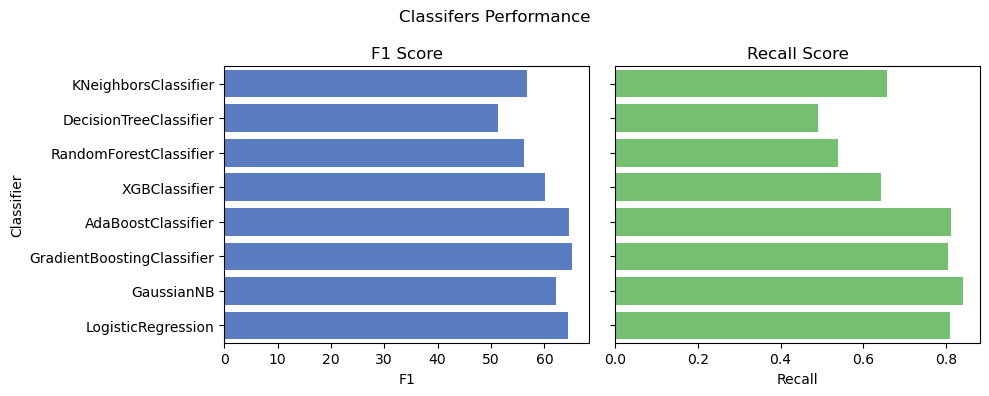

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="b", ax=ax[0])

ax[0].set_xlabel('F1')
ax[0].set_title('F1 Score')

# ax.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="g", ax=ax[1])
ax[1].set(ylabel=None)
ax[1].set_xlabel('Recall')
ax[1].set_title('Recall Score')

fig.suptitle('Classifers Performance')
plt.tight_layout()
plt.show()

### 6. Tune hyperparameters

In [21]:
best_model = GradientBoostingClassifier()
warnings.filterwarnings('ignore')
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0,1, 0.5],
}

grid_bestm = GridSearchCV(best_model, param_grid=params, cv=5, scoring='f1').fit(X_train_scaled, y_train)
print('Best parameters:', grid_bestm.best_params_)
print('Best score:', grid_bestm.best_score_)

yhat = grid_bestm.predict(X_train_scaled)
yhat_test = grid_bestm.predict(X_test_scaled)
        
print(f"Training MSE: {(mean_squared_error(y_train, yhat) / 2):.5f}")
print(f"Cross validation MSE: {(mean_squared_error(y_cv, yhat_cv) / 2):.5f}")
print(f"Test set f1 score: {f1_score(y_test, yhat_test):.5f}")
print(f"Test set accuracy score: {recall_score(y_test, yhat_test):.5f}")

Best parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Best score: 0.7797006912386852
Training MSE: 0.11505
Cross validation MSE: 0.13940
Test set f1 score: 0.64504
Test set accuracy score: 0.84712


### 7. ROC AUC and AUC graph of the best model

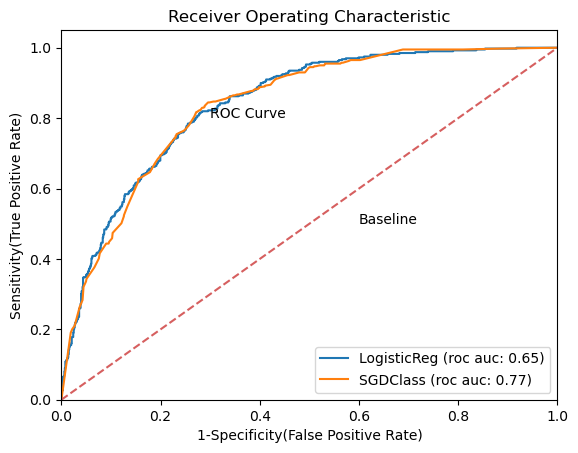

In [23]:
# Add the models to the list that you want to view on the ROC plot
models = [{'label': 'LogisticReg', 'model': base_model},
{'label': 'SGDClass', 'model': best_model}]
utils.plot_roc(models, X_test_scaled, y_test)

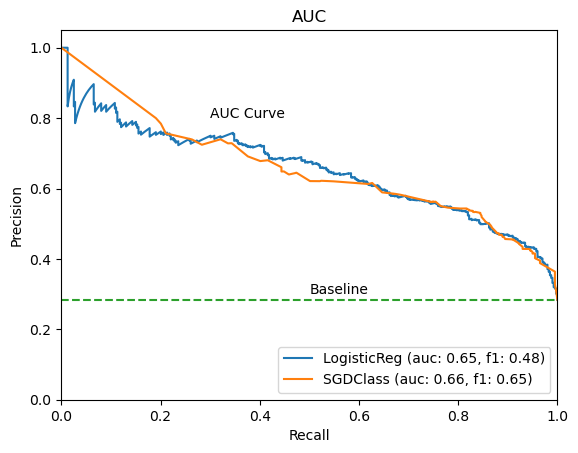

In [24]:
utils.plot_auc(models, X_test_scaled, y_test)